In [1]:
import re
import nltk
import pydot
import string
import requests
import graphviz
import numpy as np
import pandas as pd
from keras.models import Model
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping
from sklearn.naive_bayes import BernoulliNB
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
dirty = set(stopwords_list.decode().splitlines()) 

plt.style.use('default')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SamuelPorto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

O database escolhido é está disponível no kaggle como: Coronavirus tweets NLP - Text Classification (https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification).

Esse database contém tweets postados na pandemia, junto de data, localização e classificação do post. Sendo a classificação uma variável categórica ordinal (Extremely Negative, Negative, Neutral, Positive e Extremely Positive) onde os tweets negativos passam informações de insegurança e medo causado por conta do vírus e os positivos são o oposto.

Por motivos de agilidade de implementação, testes e análises neste documentos vamos considerar apenas duas categorias Negativo que encapsula as originais categorias Extremely Negative e Negative; e Positivo correspondendo as categorias Positive, Extremely Positive e Neutral.

In [2]:
train = pd.read_csv('Corona_NLP_train.csv', encoding = 'latin1')
test = pd.read_csv('Corona_NLP_test.csv', encoding = 'latin1')

In [3]:
def categorias(x):
    if x ==  "Extremely Positive":
        return "1"
    elif x == "Extremely Negative":
        return "0"
    elif x == "Negative":
        return "0"
    elif x ==  "Positive":
        return "1"
    else:
        return "0"

def sentimentos(x):
    if x == "1":
        return "Positive"
    elif x == "0":
        return "Negative"

train['label']=train['Sentiment'].apply(lambda x:categorias(x))
test['label']=test['Sentiment'].apply(lambda x:categorias(x))

train["Sentiment"] = train["label"].apply(lambda x: sentimentos(x))
test["Sentiment"] = test["label"].apply(lambda x: sentimentos(x))

In [4]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,label
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Negative,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,1
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,1
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Negative,0


In [5]:
train.label.value_counts(normalize=True)

0    0.561533
1    0.438467
Name: label, dtype: float64

# Data Prep

Vamos limpar a fontes de dados para podermos ter um melhor desempenho na modelagem.

In [6]:
# Faz o filtro de stop words, pontuações, POS e padroniza o texto
def filter_serie(serie):

    # Padrões regex que serão filtrados nos comentarios
    hyperlink = '(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+'
    date = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}'
    dinheiro = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    negacao = '([nN][ãÃaA][oO]|[ñÑ]| [nN] )'
    mencao = '@\w+'
    hash = '#\w+'
    emoji = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)

    sw = stopwords.words('portuguese')
    sw.append('\n')
    sw.append('\r')

    # Aplica o regex para remover links
    serie = serie.apply(lambda x: ' '.join(
        [re.sub(hyperlink, ' link ', word) for word in x.split()]))

    # Deixa todos os reviews em lower case
    serie = serie.apply(lambda x: ' '.join(
        [word for word in x.lower().split() if word not in (sw)]))

    # Aplica o regex para remover mencoes
    serie = serie.apply(lambda x: ' '.join(
        [re.sub(mencao, '', word) for word in x.split()]))

    # Aplica o regex para remover hashtags
    serie = serie.apply(lambda x: ' '.join(
        [re.sub(hash, '', word) for word in x.split()]))

    # Aplica o regex para remover emojis
    serie = serie.apply(lambda x: ' '.join(
        [re.sub(emoji, '', word) for word in x.split()]))

    # Aplica o regex para remover datas
    serie = serie.apply(lambda x: ' '.join(
        [re.sub(date, ' date ', word) for word in x.split()]))

    # Aplica o regex para remover valores monetários
    serie = serie.apply(lambda x: ' '.join(
        [re.sub(dinheiro, ' money ', word) for word in x.split()]))

    # Aplica o regex para padronizar negações
    serie = serie.apply(lambda x: ' '.join(
        [re.sub(negacao, ' not ', word) for word in x.split()]))

    # Aplica regex para remover caracteres especiais
    serie = serie.apply(lambda x: ' '.join(
        [re.sub('\W', ' ', word) for word in x.split()]))

    # Remove as pontuações
    serie = serie.apply(lambda x: ''.join(
        [word for word in x if word not in (string.punctuation)]))

    # Aplica regex para remover espaçamento a mais no início de cada review
    serie = serie.apply(lambda x: ' '.join(
        [re.sub('\s+', ' ', word) for word in x.split()]))

    # Aplica regex para remover espaçamento a mais no final de cada review
    serie = serie.apply(lambda x: ' '.join(
        [re.sub('[ \t]+$', '', word) for word in x.split()]))

    return serie

In [7]:
train['text'] = filter_serie(train['OriginalTweet'])
test['text'] = filter_serie(test['OriginalTweet'])

In [8]:
train[['OriginalTweet','text', 'label']].head()

,OriginalTweet,text,label
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,link and link and link,0
1,advice Talk to your neighbours family to excha...,advice talk to your neighbours family to excha...,1
2,Coronavirus Australia: Woolworths to give elde...,coronavirus australia woolworths to give elder...,1
3,My food stock is not the only one which is emp...,my food stock is not the only one which is lin...,1
4,"Me, ready to go at supermarket during the #COV...",me ready to go at supermarket during the outbr...,0


In [9]:
vectorizer = CountVectorizer(binary=True)

X_train = vectorizer.fit_transform(train['text'])
X_test = vectorizer.transform(test['text'])

y_train = train['label']
y_test = test['label']

# Naive Bayes

In [10]:
model = BernoulliNB()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.82      0.81      2252
           1       0.73      0.69      0.71      1546

    accuracy                           0.77      3798
   macro avg       0.76      0.76      0.76      3798
weighted avg       0.77      0.77      0.77      3798



# Logistic Regression

In [11]:
model_lr = LogisticRegression()

model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_test)

print(classification_report(y_test, y_pred))
print(model_lr.classes_)

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2252
           1       0.85      0.83      0.84      1546

    accuracy                           0.87      3798
   macro avg       0.87      0.86      0.86      3798
weighted avg       0.87      0.87      0.87      3798

['0' '1']


c:\Users\SamuelPorto\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Como o modelo de regressão logística apresentou um desempenho melhor, vamos analisar quais as palavras significativas para cada categoria

In [12]:
vocab = vectorizer.vocabulary_

palavras_negativas = []

palavras_postivas = []

for t in vocab.keys():
    coef = model_lr.coef_[0, vocab[t]]
    
    if coef < 0:
        palavras_negativas.append((-coef, t))
    else:
        palavras_postivas.append((coef, t))

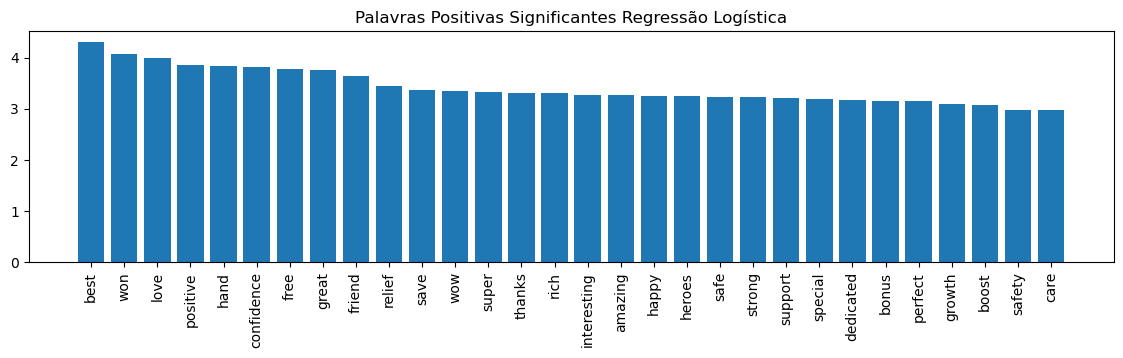

In [13]:
tuplas_ordenadas = sorted(palavras_postivas, reverse=True)

palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]

n_palavras = 30
eixo_x = np.arange(n_palavras)

plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=90)
plt.title("Palavras Positivas Significantes Regressão Logística")
plt.show()

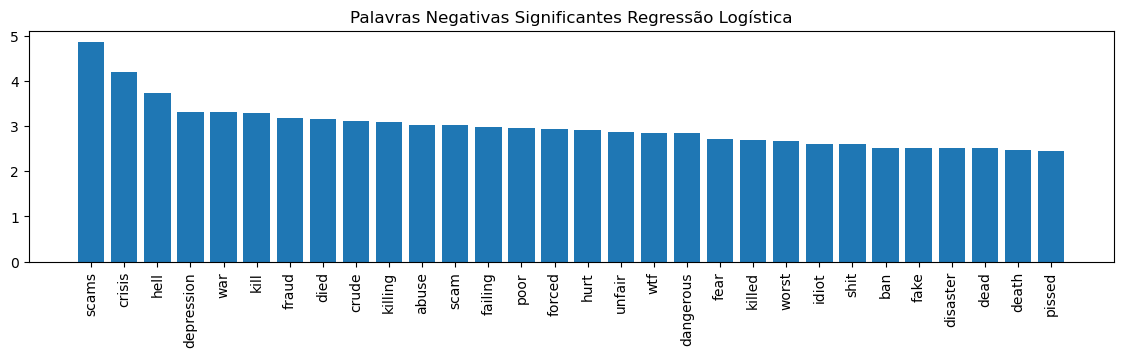

In [14]:
tuplas_ordenadas = sorted(palavras_negativas, reverse=True)

palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]

n_palavras = 30
eixo_x = np.arange(n_palavras)

plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=90)
plt.title("Palavras Negativas Significantes Regressão Logística")
plt.show()

# Neural Network

In [15]:
vectorizer = CountVectorizer(binary=True, stop_words=dirty, max_features=1000, max_df=0.4)

X_train = vectorizer.fit_transform(list(train['text'])).toarray()
X_test = vectorizer.transform(list(test['text'])).toarray()

y_train = train['label']
y_test = test['label']

c:\Users\SamuelPorto\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['articl', 'mon'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [16]:
ohe = OneHotEncoder()

labels_train = np.array([list(train['Sentiment'])]).T
labels_test = np.array([list(test['Sentiment'])]).T

y_train = ohe.fit_transform(labels_train).toarray()
y_test = ohe.fit_transform(labels_test).toarray()

In [17]:
def rede_neural_simples(input_dims, n_dims_out):
  input_layer = Input(shape=(input_dims,))
  
  x = input_layer
  y = Dense(n_dims_out, activation='sigmoid', name='classificador')(x)

  return Model(input_layer, y)

In [18]:
rede_neural = rede_neural_simples(X_train.shape[1], y_train.shape[1])
rede_neural.compile(optimizer='adam', loss='mse')

plot_model(rede_neural, show_shapes=True, show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [19]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = rede_neural.fit(X_train, y_train, epochs=500, validation_split=0.2, callbacks=es)

Epoch 1/500
1029/1029 [==============================] - 3s 2ms/step - loss: 0.2222 - val_loss: 0.2074
Epoch 2/500
1029/1029 [==============================] - 2s 2ms/step - loss: 0.1942 - val_loss: 0.1906
Epoch 3/500
1029/1029 [==============================] - 2s 2ms/step - loss: 0.1808 - val_loss: 0.1808
Epoch 4/500
1029/1029 [==============================] - 2s 2ms/step - loss: 0.1725 - val_loss: 0.1745
Epoch 5/500
1029/1029 [==============================] - 2s 2ms/step - loss: 0.1669 - val_loss: 0.1701
Epoch 6/500
1029/1029 [==============================] - 2s 2ms/step - loss: 0.1629 - val_loss: 0.1669
Epoch 7/500
1029/1029 [==============================] - 2s 2ms/step - loss: 0.1600 - val_loss: 0.1646
Epoch 8/500
1029/1029 [==============================] - 2s 2ms/step - loss: 0.1577 - val_loss: 0.1627
Epoch 9/500
1029/1029 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1613
Epoch 10/500
1029/1029 [==============================] - 2s 2ms/step - l

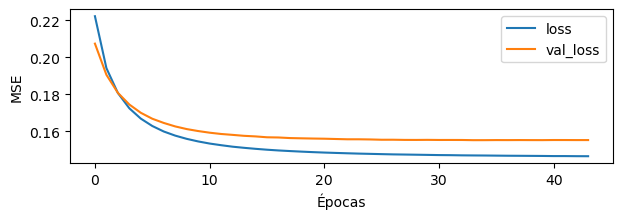

In [20]:
plt.figure(figsize=(7,2))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [21]:
y_est = rede_neural.predict(X_test)

print(y_est[0:5,:])
print(y_test[0:5,:])

119/119 [==============================] - 0s 1ms/step
[[0.7587186  0.24109718]
 [0.11928604 0.8804493 ]
 [0.3085145  0.69136316]
 [0.8388373  0.16124924]
 [0.79362875 0.20581818]]
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [22]:
print(classification_report(ohe.inverse_transform(y_test), ohe.inverse_transform(y_est)))

              precision    recall  f1-score   support

    Negative       0.77      0.87      0.82      2252
    Positive       0.77      0.63      0.69      1546

    accuracy                           0.77      3798
   macro avg       0.77      0.75      0.75      3798
weighted avg       0.77      0.77      0.77      3798



In [23]:
w = rede_neural.get_layer('classificador').get_weights()

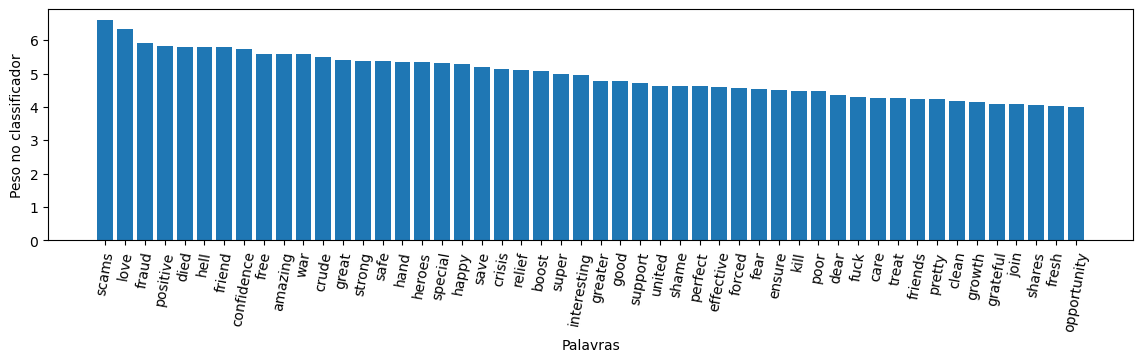

In [24]:
# Visualização 1: quais são as palavras de maior peso?
pesos = np.abs(w[0][:,0] - w[0][:,1])
feature_names = vectorizer.get_feature_names() # Modificar isso para versões mais atuais do sklearn
pares = [ (pesos[i], feature_names[i]) for i in range(len(feature_names))]
pares = sorted(pares, reverse=True)
pesos_ = [c[0] for c in pares]
palavras_ = [c[1] for c in pares]

n_palavras = 50
plt.figure(figsize=(14,3))
plt.bar(np.arange(n_palavras), pesos_[0:n_palavras])
plt.xticks(np.arange(n_palavras), palavras_[0:n_palavras], rotation=80)
plt.xlabel('Palavras')
plt.ylabel('Peso no classificador')
plt.show()

Podemos observar que essa implementação de Rede Neural simples não é muito efetiva e perde em questão de desempenho para a Regressão Logística, vamos agora analisar o desempenha desempenho de outra rede neural.

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/500
1029/1029 [==============================] - 3s 2ms/step - loss: 0.2096 - val_loss: 0.1791
Epoch 2/500
1029/1029 [==============================] - 2s 2ms/step - loss: 0.1645 - val_loss: 0.1612
Epoch 3/500
1029/1029 [==============================] - 3s 3ms/step - loss: 0.1541 - val_loss: 0.1576
Epoch 4/500
1029/1029 [==============================] - 2s 2ms/step - loss: 0.1513 - val_loss: 0.1556
Epoch 5/500
1029/1029 [==============================] - 2s 2ms/step - loss: 0.1503 - val_loss: 0.1561
Epoch 6/500
1029/1029 [==============================] - 2s 2ms/step - loss: 0.1499 - val_loss: 0.1559
Epoch 7/500
1029/1029 [==============================] - 2s 2ms/step - loss: 0.1495 - val_loss: 0.1556
Epoch 8/500
1029/1029 [==============================] - 2s 2ms/step - loss: 0.1494 - val_loss: 0.1558
Epoch 9/500
10

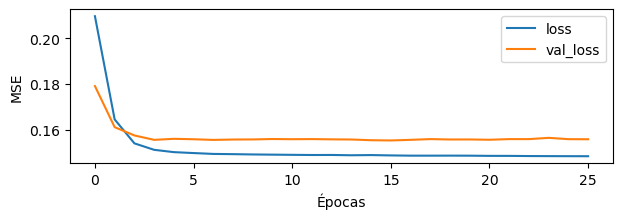

119/119 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

    Negative       0.78      0.87      0.82      2252
    Positive       0.76      0.64      0.70      1546

    accuracy                           0.77      3798
   macro avg       0.77      0.75      0.76      3798
weighted avg       0.77      0.77      0.77      3798



In [25]:
def rede_neural_proj(input_dims, n_dims_out):
  input_layer = Input(shape=(input_dims,))

  x = input_layer
  x = Dense(2, name='projecao')(x)
  y = Dense(n_dims_out, activation='sigmoid', name='classificador')(x)
  
  return Model(input_layer, y)

rede_neural = rede_neural_proj(X_train.shape[1], y_train.shape[1])
rede_neural.compile(optimizer='adam', loss='mse')

plot_model(rede_neural, show_shapes=True, show_layer_activations=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

history = rede_neural.fit(X_train, y_train, epochs=500, validation_split=0.2, callbacks=es)

plt.figure(figsize=(7,2))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.show()

y_est = rede_neural.predict(X_test)
print(classification_report(ohe.inverse_transform(y_test), ohe.inverse_transform(y_est)))

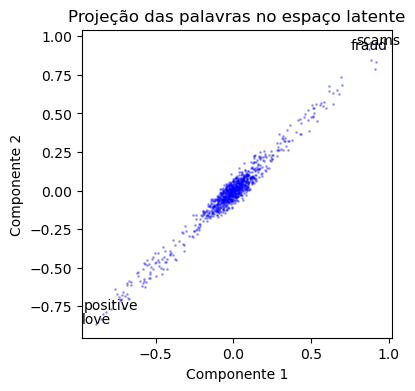

In [28]:
# Visualização 2: onde foi parar cada palavra?
v = rede_neural.get_layer('projecao').get_weights()[0]

plt.figure(figsize=(4,4))
plt.scatter(v[:,0], v[:,1], s=1, alpha=0.3, c='b')

for s in palavras_[0:4]:
    _n = vectorizer.vocabulary_[s]
    plt.text(v[_n,0], v[_n,1], s, ha='center')
    
plt.title('Projeção das palavras no espaço latente')
plt.ylabel('Componente 2')
plt.xlabel('Componente 1')
#plt.xlim([-20,20])
#plt.ylim([-20,20])
plt.show()

Essa segunda rede neural possui um desempenho similar a primeira, contudo, ao projetar as palavras no espaço latente conseguimos observar que o modelo consegui distinguir os extremos, mas para os elementos centrais é difícil ele acertar.